In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
import torch
import numpy as np
import utils
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle
%load_ext autoreload
import string
np.random.seed(2) 
torch.manual_seed(2)

In [53]:
%autoreload

In [4]:
lcs = utils.get_data('../../datasets/ZTF_gri', test_split=0.0,keep_missing=True, min_length=25)


found 3408 for band='r'
found 3408 for band='i'
found 3408 for band='g'
max time:  1687.1758
created union_tp attribute of length 3500
dataset created, lcs.dataset.shape=(2985, 3, 4396, 3)
train size: 2985, valid size: 597, test size: 0


In [7]:
net,optimizer,scheduler,lrs,args,epoch,losses = utils.load_checkpoint('../checkpoints/gri/ZTF_gri0.8933992385864258.h5', lcs.data_obj,device='mps')

=> loading checkpoint '../checkpoints/gri/ZTF_gri0.8933992385864258.h5'
Namespace(data_folder='/home2/fggr82/astr/hetast/src/datasets/ZTF_gri', start_col=1, checkpoint=None, seed=2, device='mps', net='HeTVAE', mixing='concat', n_union_tp=3500, embed_time=128, num_heads=8, latent_dim=64, num_ref_points=16, rec_hidden=128, width=512, niters=6000, patience=10000, batch_size=2, k_iwae=1, lr=0.0001, beta1=0.9, beta2=0.999, scheduler=True, warmup=10, factor=0.9, lr_patience=35, threshold=0.01, dropout=0.1, inc_errors=False, frac=0.5, mse_weight=5.0, kl_annealing=True, kl_itrs=6000, n_cycles=32, start=0.0, stop=0.8, ratio=0.5, keep_missing=False, min_length=25, print_at=1, save_at=30, kl_zero=False, const_var=False, var_per_dim=False, num_resamples=0, is_bounded=True)


In [8]:
avg_nll, avg_mse, indy_nll = utils.evaluate_hetvae(net,lcs.data_obj['input_dim'],lcs.data_obj['test_loader'],frac=0.5,k_iwae=1,device='mps')
avg_nll, avg_mse, indy_nll 

/Users/mattlowery/Desktop/Desko/code/astro/hetast/src/layers.py:83: UserWarning: MPS: no support for int64 repeats mask, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Repeat.mm:236.)
  scores = scores.unsqueeze(-1).repeat_interleave(dim, dim=-1)

KeyboardInterrupt



In [9]:
qzs,disc_path = utils.encode(lcs.data_obj['train_loader'], net, device='mps')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 611/611 [00:14<00:00, 40.89it/s]


In [10]:
num_ref_points = 16 #args.num_ref_points
latent_dim = 64     #args.latent_dim
l = len(lcs.dataset)
n_samples = 10
zs = (np.random.randn(n_samples, qzs.shape[0], qzs.shape[2],qzs.shape[3]) * qzs[:,1,:,:] + qzs[:,0,:,:]).mean(0)

In [11]:
print(zs.shape,disc_path.shape)

(1221, 16, 64) (1221, 16, 64)


In [3]:
zs = np.loadtxt('./zs_gri.dat')

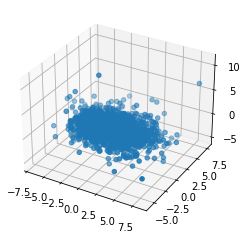

In [5]:
RS = 20150101
pca = PCA(random_state=RS)
pca3d = pca.fit_transform(zs.reshape(zs.shape[0],-1)) 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pca3d[:,0],pca3d[:,1],pca3d[:,2])


Text(0.5, 1.0, 'Explained Variance Ratio for gr model')

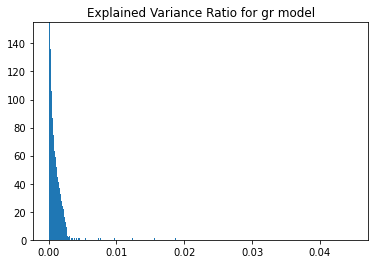

In [19]:
plt.hist(pca.explained_variance_ratio_,bins=np.arange(0.0,0.045,step=0.00015))
plt.ylim(0,155)
plt.title('Explained Variance Ratio for gr model')
#plt.savefig('../img/pca_gr/var_ratio')

In [35]:
%autoreload

In [27]:
# bins for PC 0


r1,r2 = np.min(pca3d[:,0]), np.max(pca3d[:,0])
bins1 = np.arange(r1,r2, step=(r2-r1)/bins)
bin_i = np.digitize(pca3d[:,0],bins=bins1) - 1
zs[bin_i==0].shape


(24, 1024)

In [48]:
np.where(bin_i==7)

(array([  18,  220,  260,  384,  411,  586,  651,  770,  853,  867,  917,
        1019, 1173, 1175, 1485]),)

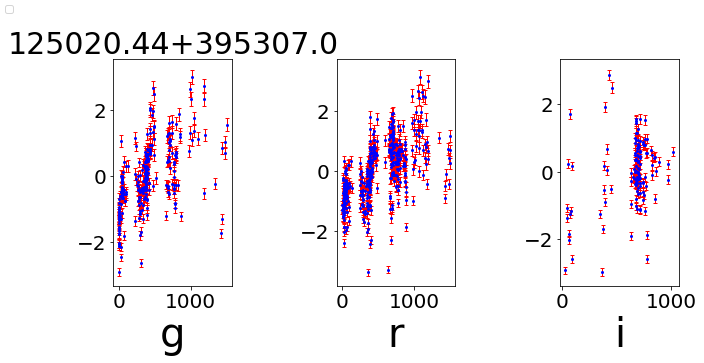

In [63]:
utils.preview_lcs(lcs, [1485],figsize=[10,5])

# bins for different pcs for 2 dims

In [13]:
bins = 5
interpols = []
pca_comps = 10
for i in [1]: # first 4 pcs
    r1,r2 = np.min(pca3d[:,i]), np.max(pca3d[:,i])
    bins1 = np.arange(r1,r2, step=(r2-r1)/bins)
    
    bin_i = np.digitize(pca3d[:,i],bins=bins1) # which light curve belongs to which bin? 
    print(np.unique(bin_i))
    for b in range(1,bins+1):
        print(zs[bin_i==b].shape)
        print(np.where(bin_i==b))
    # average light curves across bins 
#     avgs = [np.concatenate((zs[bin_i==i].mean(0)[np.newaxis],disc_path[bin_i==i].mean(0)[np.newaxis]), axis=0) \
#      for i in range(1,bins+1)]
    
#     avgs = np.array(avgs,dtype=np.float32)
#     #print(avgs.shape)
#     target_tp = np.arange(0,1500,step=2.5, dtype=np.float32)
#     target_tp = target_tp[np.newaxis].repeat(len(lcs.bands),axis=0)[np.newaxis].repeat(len(bins1),axis=0)
# #     interps = utils.decode(net,zs=avgs[:,0],disc_path=avgs[:,1],target_x=target_tp,device='mps', batch_size=2)
#     interpols.append(interps)
    


[1 2 3 4 5]
(34, 1024)
(array([  26,   73,   75,  100,  115,  132,  135,  217,  233,  267,  270,
        332,  384,  395,  396,  415,  478,  523,  772,  911,  927,  932,
       1006, 1007, 1052, 1067, 1071, 1101, 1105, 1112, 1210, 1296, 1459,
       1516]),)
(563, 1024)
(array([   3,    4,    7,   12,   15,   16,   18,   21,   22,   23,   28,
         29,   34,   35,   39,   41,   42,   56,   57,   58,   59,   64,
         65,   68,   69,   70,   71,   74,   76,   79,   82,   83,   84,
         86,   90,   91,   96,   97,  101,  102,  108,  112,  113,  114,
        118,  120,  126,  127,  129,  130,  133,  136,  137,  140,  141,
        144,  148,  149,  150,  152,  154,  157,  158,  159,  163,  164,
        170,  172,  178,  180,  181,  186,  190,  193,  194,  196,  198,
        199,  200,  201,  203,  205,  211,  212,  213,  219,  222,  229,
        231,  246,  247,  251,  253,  255,  256,  259,  261,  262,  264,
        265,  266,  275,  279,  280,  283,  285,  287,  290,  294,  303

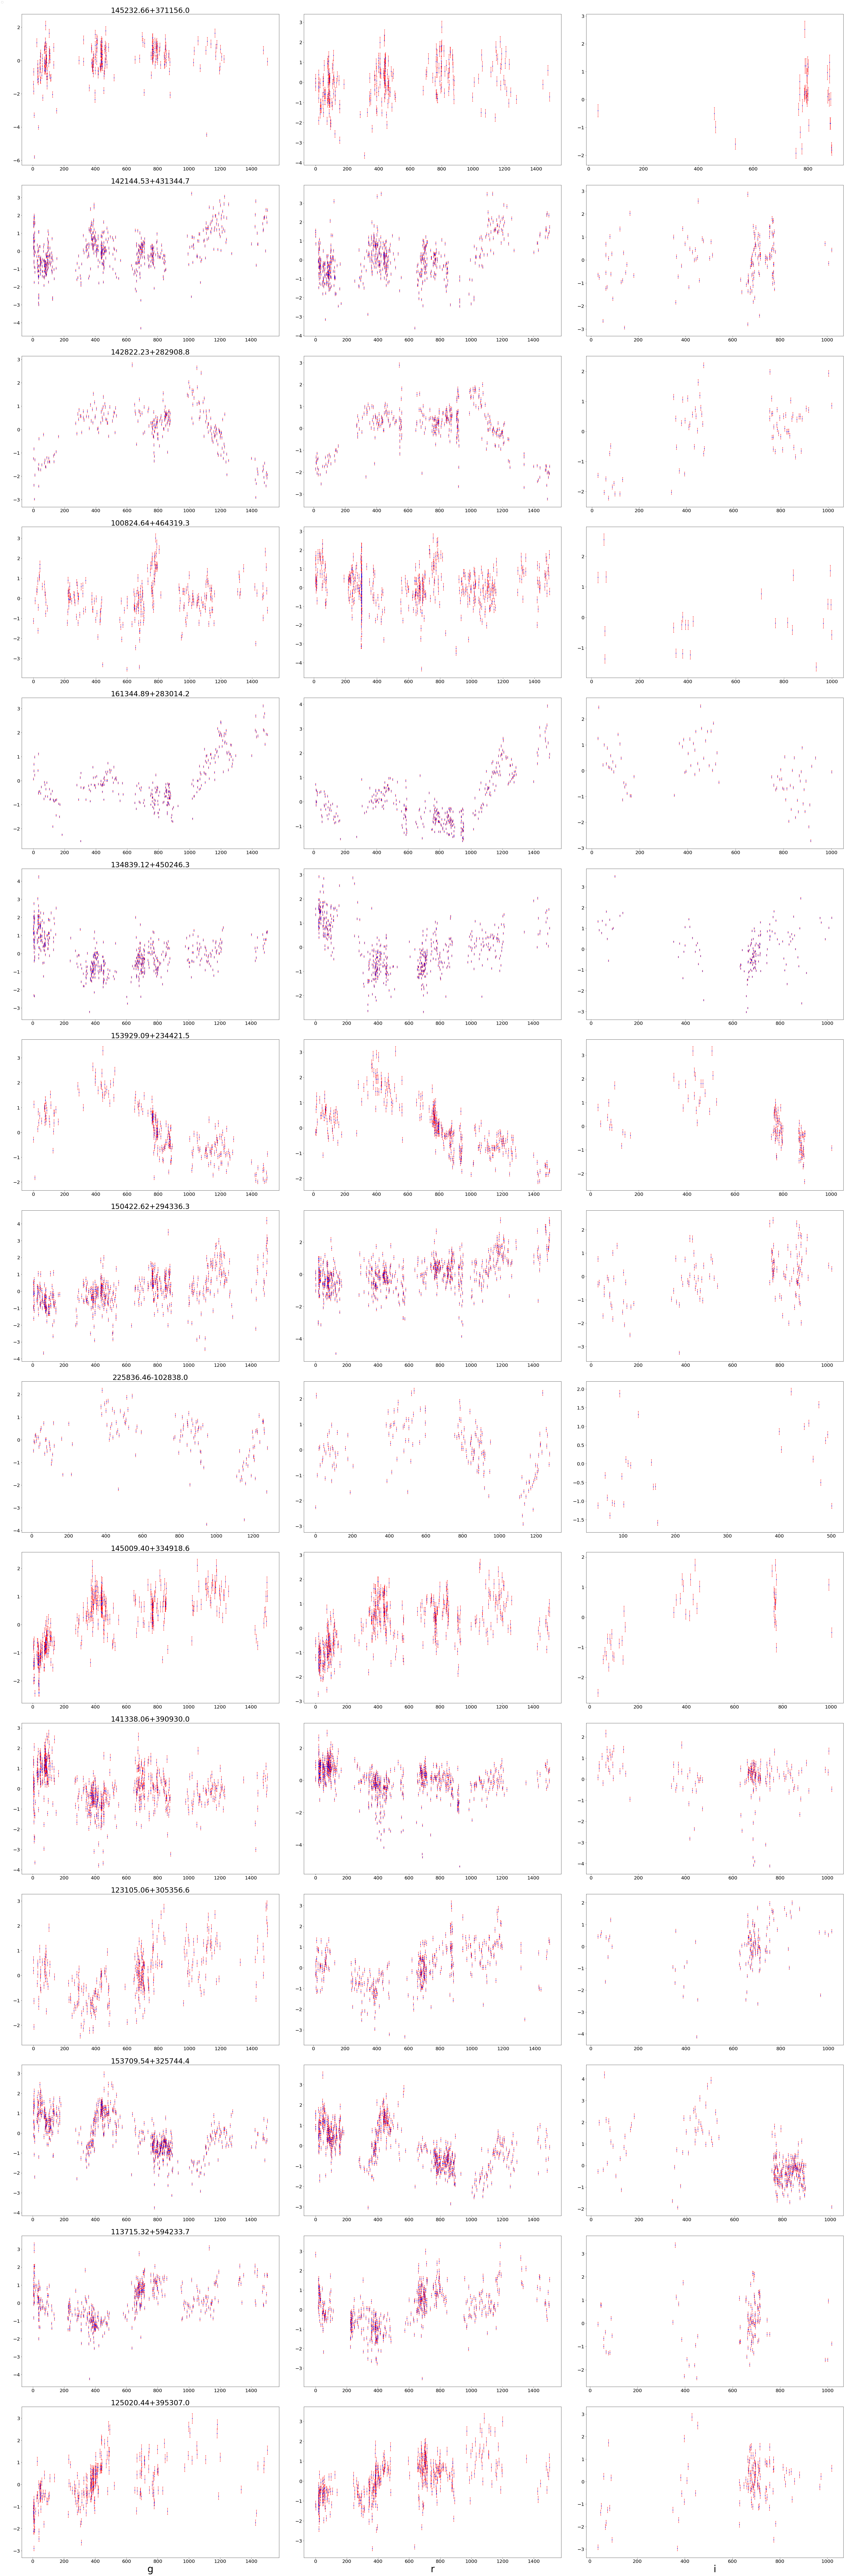

In [163]:
utils.preview_lcs(lcs,[  18,  220,  260,  384,  411,  586,  651,  770,  853,  867,  917,
       1019, 1173, 1175, 1485],figsize=[50,150])

In [87]:
zs[bin_i==1]

array([], shape=(0, 1024), dtype=float64)

In [17]:
import pickle
with open('interpols.pkl', 'wb') as f:  # Overwrites any existing file.
    pickle.dump(interpols, f, pickle.HIGHEST_PROTOCOL)

In [38]:
lcs.bands

['r', 'i', 'g']

In [133]:
with open('interpols_gri.pkl', 'rb') as f:
    interpols = pickle.load(f)

In [76]:
bins = 8
pca_comps = 10

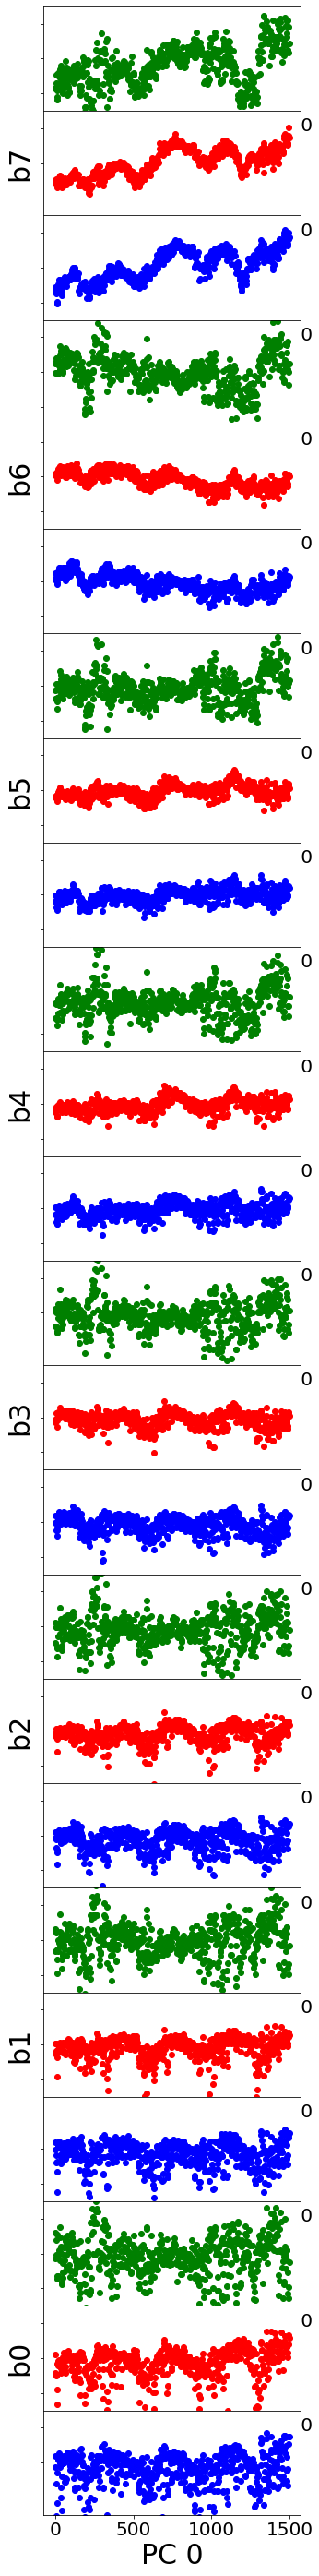

In [164]:
fs = 30
dims = interpols[0].shape[1]
colors = ['g','r','b']
fig,ax = plt.subplots(bins*dims,pca_comps, figsize=(50,50),squeeze=False)
for i in range(10):
    ax[bins*dims-1,i].set_xlabel(f'PC {i}',fontsize=fs)
    for bin in range(0,bins*dims,3):
        interps = interpols[i]
        ###### labeling #######
        s2s = []
        for j, dim in enumerate([2,0,1]): # order of dimensions needs to be g,r,i
            lc = interpols[i][int(bin/3),dim,:,:2]
            s2 = round((1/(len(lc)-1)) * ((lc[:,1] - np.mean(lc[:,1]))**2).sum(),4)
            s2s.append(s2)
        ax[~(bin+1),0].set_ylabel(f'b{int(bin/3)}',fontsize=fs)
        ################
        for j, dim in enumerate([1,0,2]):
            ax[~(bin+j),i].set_ylim(-1.5,1.5)
            ax[~(bin+j),i].scatter(interps[int(bin/3),dim,:,0], interps[int(bin/3),dim,:,1],c=colors[~j])
            ax[~(bin+j),i].set_yticklabels([])
#             if lcs.bands[dim] == 'r':
#                 s2 = s2s[0] - s2s[1]
#                 ax[~(bin+dim),i].text(0,1.0,"{0:+.03f}".format(s2),fontsize=40)
#             else:
#                 s2 = s2s[1]
#                 ax[~(bin+dim),i].text(0,1.0,s2,fontsize=40)
#                 ax[~(bin+dim),i].vlines(0,-1.5,-1.5 + s2*10, colors='red')
     

# fig.text(0.2,0.42,'g',fontsize=120,color='g')
# fig.text(0.25,0.33,'r',fontsize=120,color='r')

plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig('../img/pca_gr/recons_uniftp')
for i in range(1,pca_comps):
    for j in range(bins*3):
        fig.delaxes(ax[j,i])


In [ ]:
# where are the noisey light curves in the latent space? 

In [81]:
with open('interpols_gri_blend.pkl', 'rb') as f:
    interps = pickle.load(f)

In [82]:
interps = interps.reshape(7,7,3,600,3)

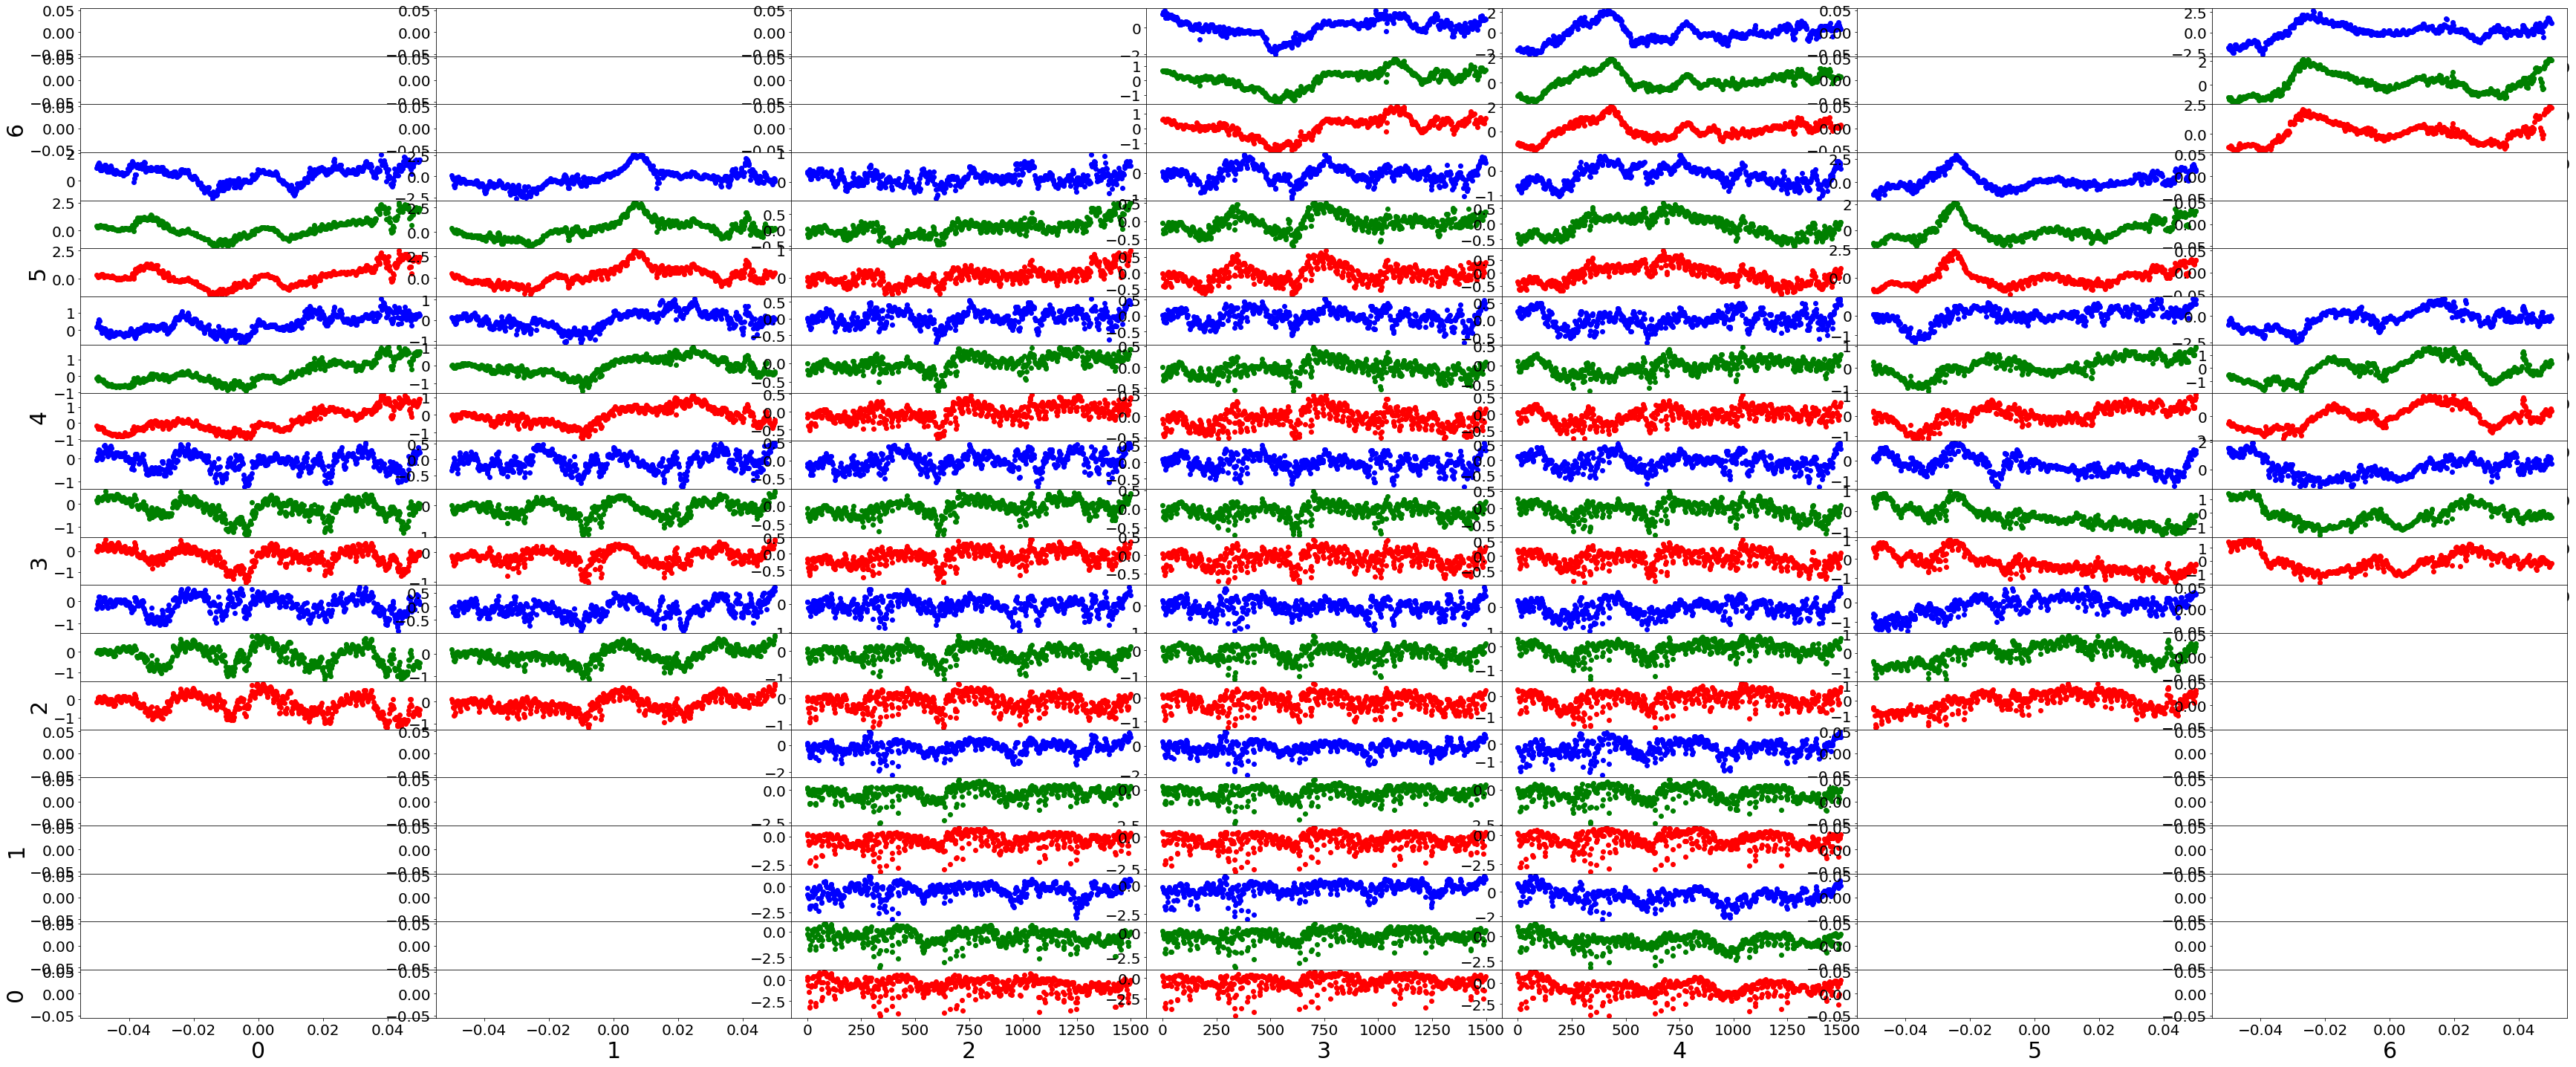

In [83]:
bins = 7
dims = len(lcs.bands)
fs=30
fig,ax = plt.subplots(bins*3,bins,figsize=(60,25))
for i in range(0,bins*3, 3):
    ax[~i,0].set_ylabel(int(i/3),fontsize=fs)
    for j in range(bins):
        ax[~0,j].set_xlabel(j,fontsize=fs)
        for k, dim in enumerate([1,0,2]):
            ax[~(i+k),j].scatter(interps[int(i/3),j,dim,:,0], interps[int(i/3),j,dim,:,1],c=colors[dim])
            
# fig.text(0.2,0.87,'g',fontsize=100,color='g')
# fig.text(0.2,0.80,'r',fontsize=100,color='r')
# ax[1,0].text(0,0,'r',c='r',fontsize=100)
plt.subplots_adjust(wspace=0, hspace=0)     
# plt.savefig('../img/pca_gr/recons_blend')

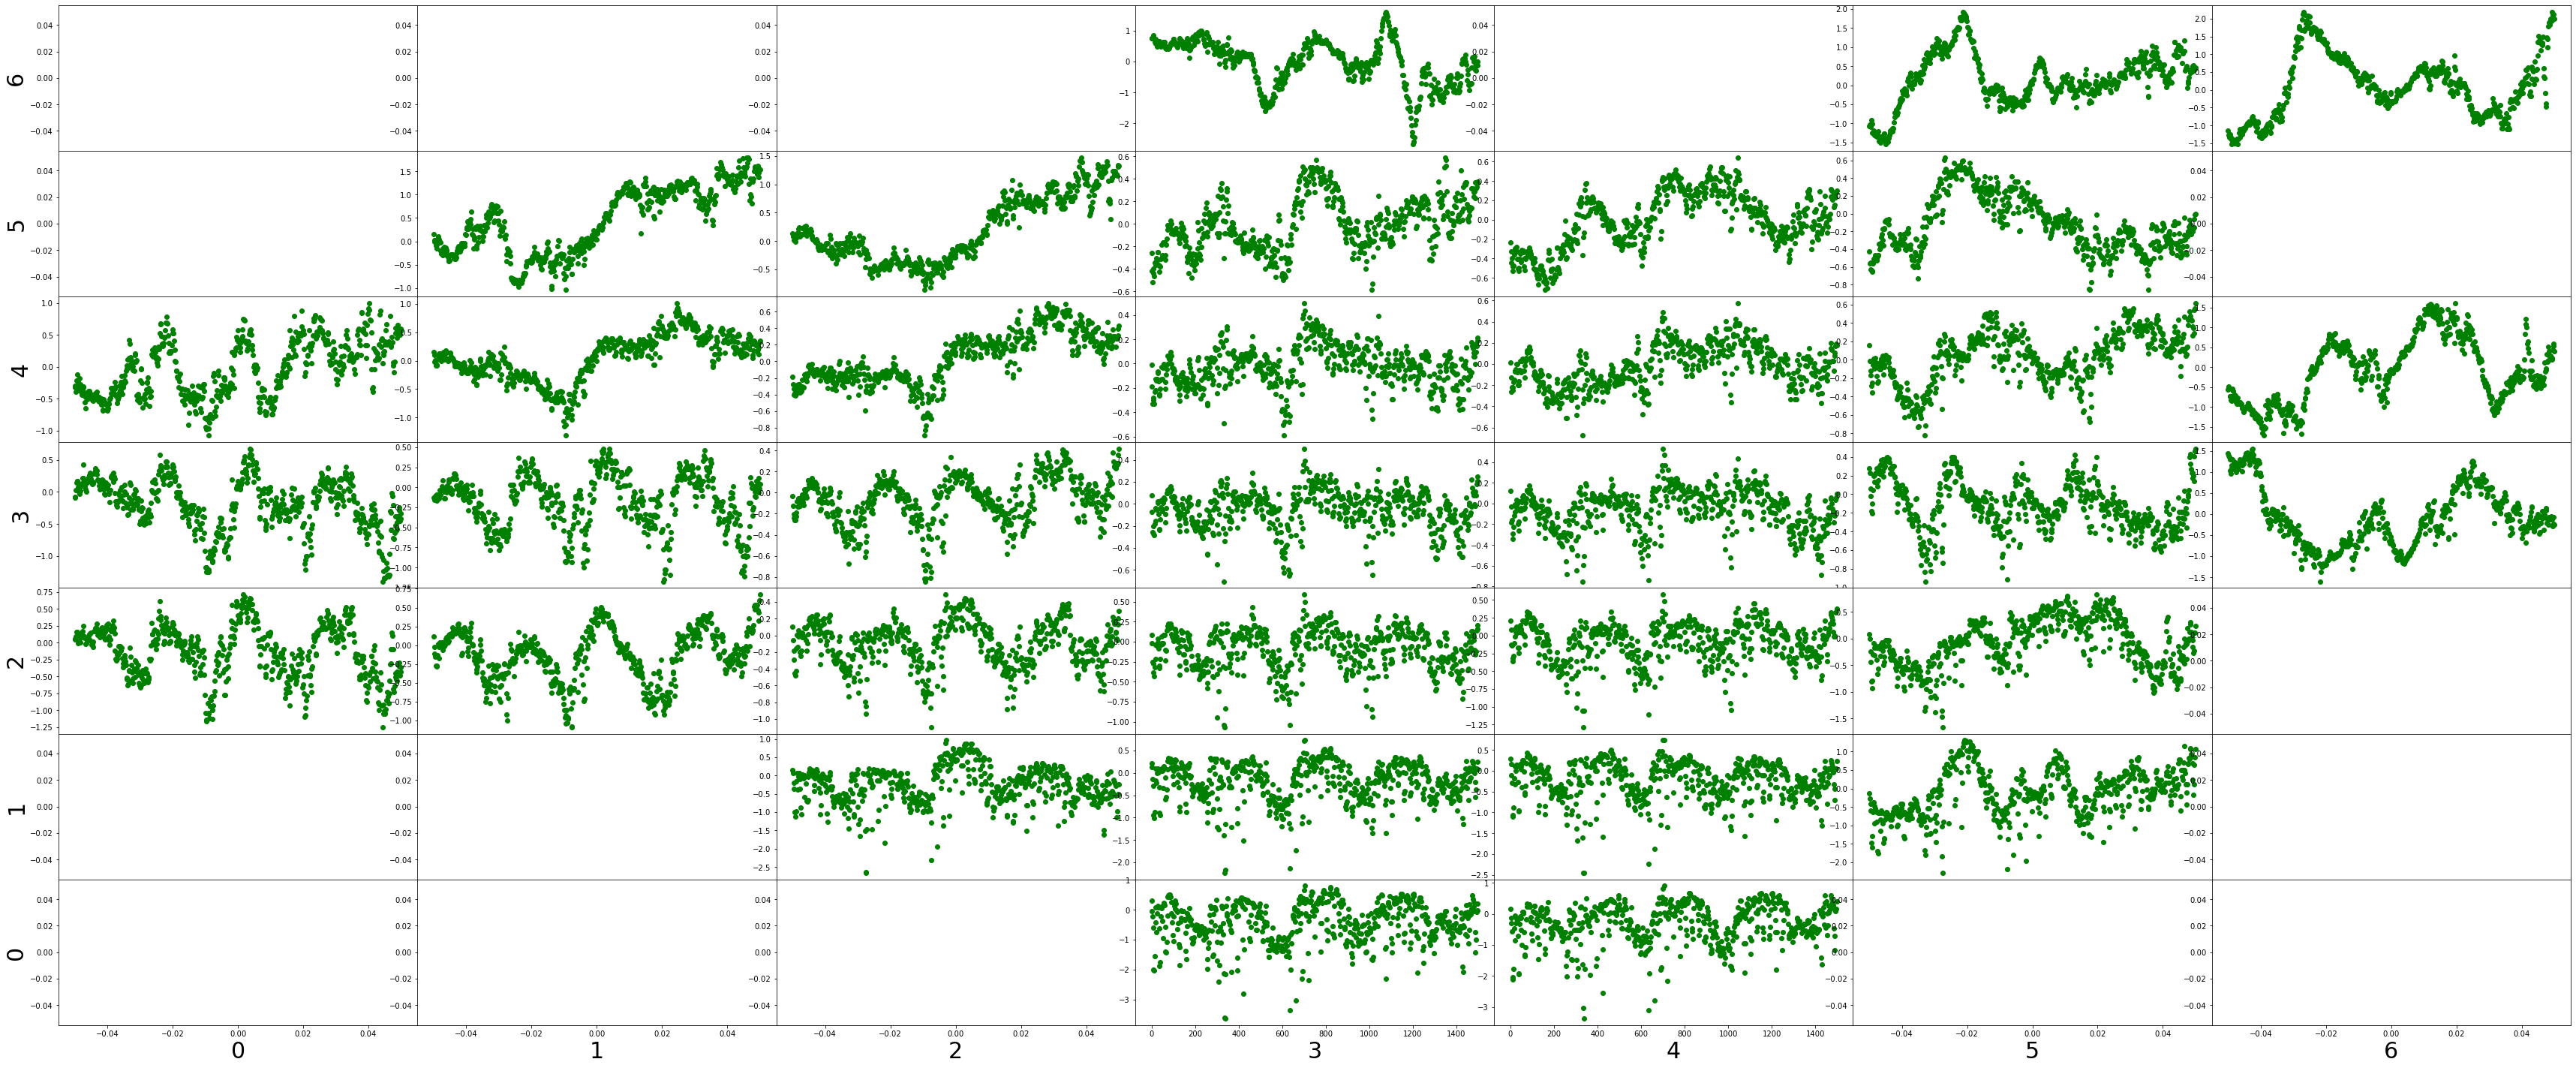

In [34]:
bins = 7
show=1
order=[1,0,2]
dims = len(lcs.bands)
fs=30
fig,ax = plt.subplots(bins*show,bins,figsize=(60,25))
for i in range(0,bins*show, show):
    ax[~i,0].set_ylabel(int(i/show),fontsize=fs)
    for j in range(bins):
        ax[~0,j].set_xlabel(j,fontsize=fs)
        for k, dim in enumerate([0]):
            ax[~(i+k),j].scatter(interps[int(i/show),j,dim,:,0], interps[int(i/show),j,dim,:,1],c=colors[dim])
            
# fig.text(0.2,0.87,'g',fontsize=100,color='g')
# fig.text(0.2,0.80,'r',fontsize=100,color='r')
# ax[1,0].text(0,0,'r',c='r',fontsize=100)
plt.subplots_adjust(wspace=0, hspace=0)     
# plt.savefig('../img/pca_gr/recons_blend')